In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%cd /Midgard/home/amirme/an_explanation_model
from source.project_manager import (
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from source.data_manager import preprocess_masks,plot_masks,minmax_normalize,sum_channels,symmetric_minmax_normalize
from source.labels import IMAGENET_LABELS
imshow_args = {"cmap": "viridis" , "vmin": 0, "vmax": 1}

/Midgard/home/amirme/an_explanation_model


2023-09-21 09:17:57.392775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 09:18:02.304211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/Midgard/home/amirme/miniconda3/envs/xmodel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_metadata = load_experiment_metadata(glob_path="experiment_4/*")
print(project_metadata.columns)
project_metadata = project_metadata.set_index(
    [
        "stream_name",
        "stream_statistic",
        "image_index",
        "baseline_mask_type",
        "alpha_mask_value",
    ]
).sort_index()
print(project_metadata.shape)

Index(['method', 'alpha_mask_type', 'alpha_mask_value', 'projection_type',
       'projection_top_k', 'baseline_mask_type', 'baseline_mask_value',
       'normalize_sample', 'write_demo', 'architecture', 'max_batches',
       'min_change', 'seed', 'batch_size', 'num_classes', 'input_shape',
       'image_index', 'monitored_statistic', 'monitored_stream', 'dataset',
       'output_layer', 'label', 'image_path', 'time_to_compute', 'batch_index',
       'monitored_statistic_change', 'data_path', 'stream_name',
       'stream_statistic', 'csv_file_path'],
      dtype='object')
(588, 25)


In [15]:
vc = project_metadata.index.value_counts()
print(vc)
print(len(vc))
image_indices = project_metadata.index.get_level_values("image_index").unique()

stream_name            stream_statistic  image_index  baseline_mask_type  alpha_mask_value
alpha_mask             none              3            static              0.0                 1
results_at_projection  none              5            static              0.1                 1
                       meanx             11           static              0.7                 1
                                                                          0.8                 1
                                                                          0.9                 1
                                                                                             ..
log_probs              meanx             5            gaussian            0.6                 1
                                                      static              0.0                 1
                                                                          0.1                 1
                                             

['alpha_mask_value']


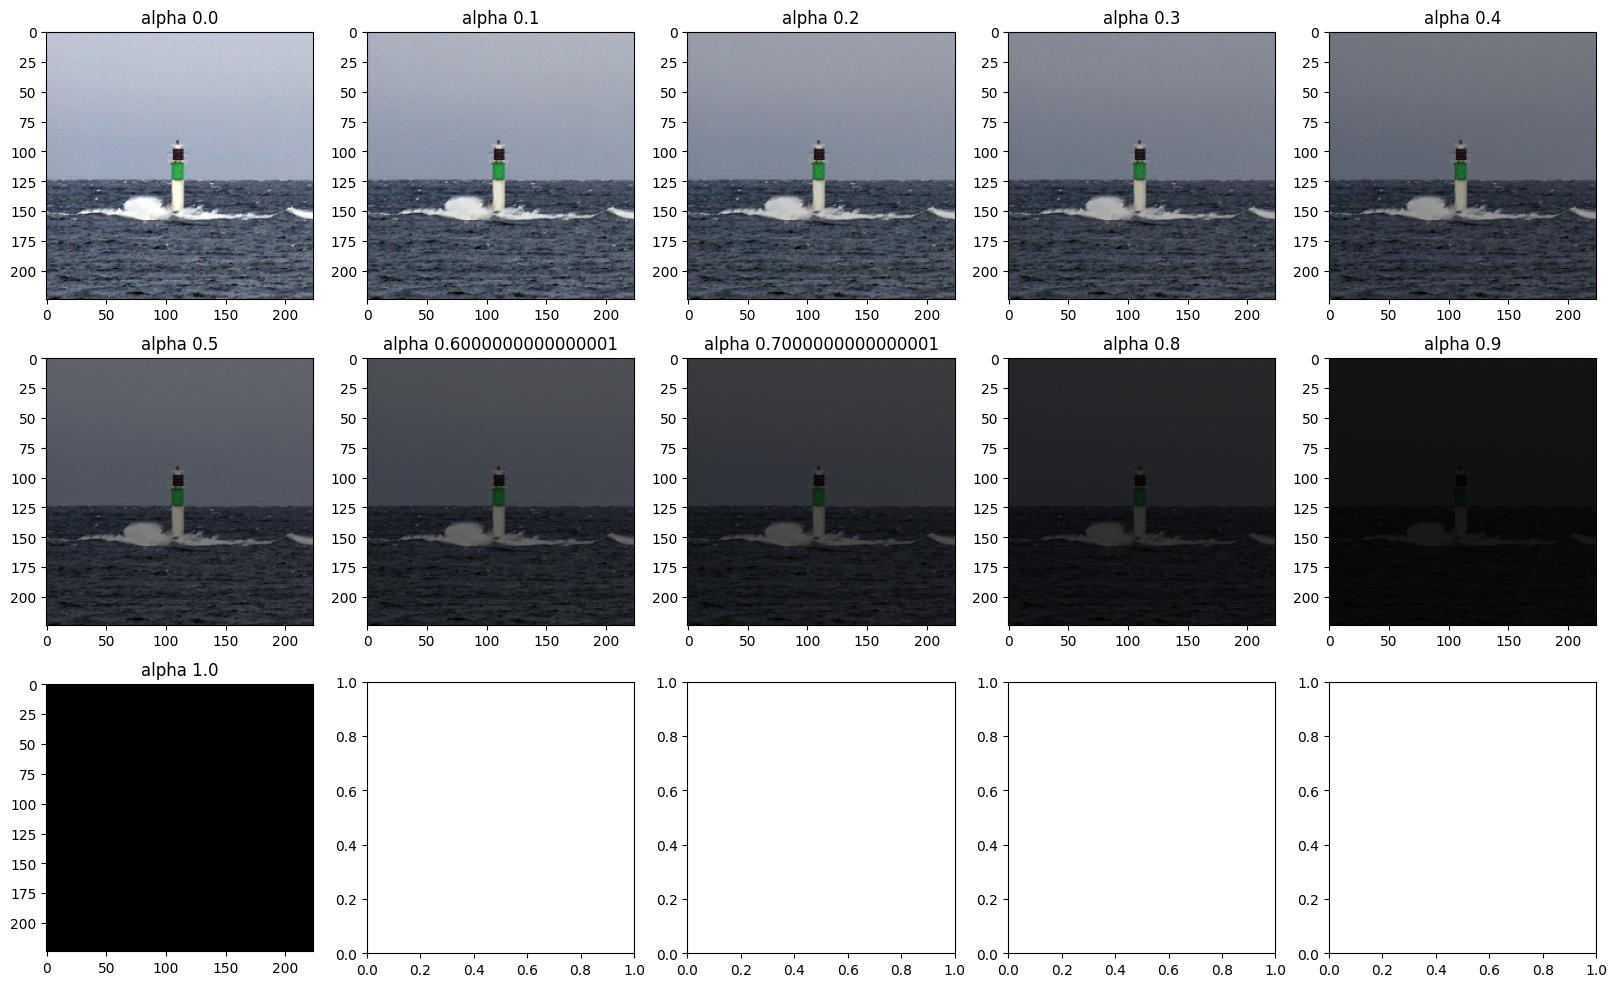

In [24]:
temp_data = project_metadata.loc[("convex_combination_mask","none",9,"static"),"data_path"].apply(lambda x: np.load(x))
print(temp_data.index.names)
titles = temp_data.index.to_series().apply(lambda x: f"alpha {x}")
plot_masks(temp_data, titles=titles, imshow_args=imshow_args, ncols=5)

['alpha_mask_value']


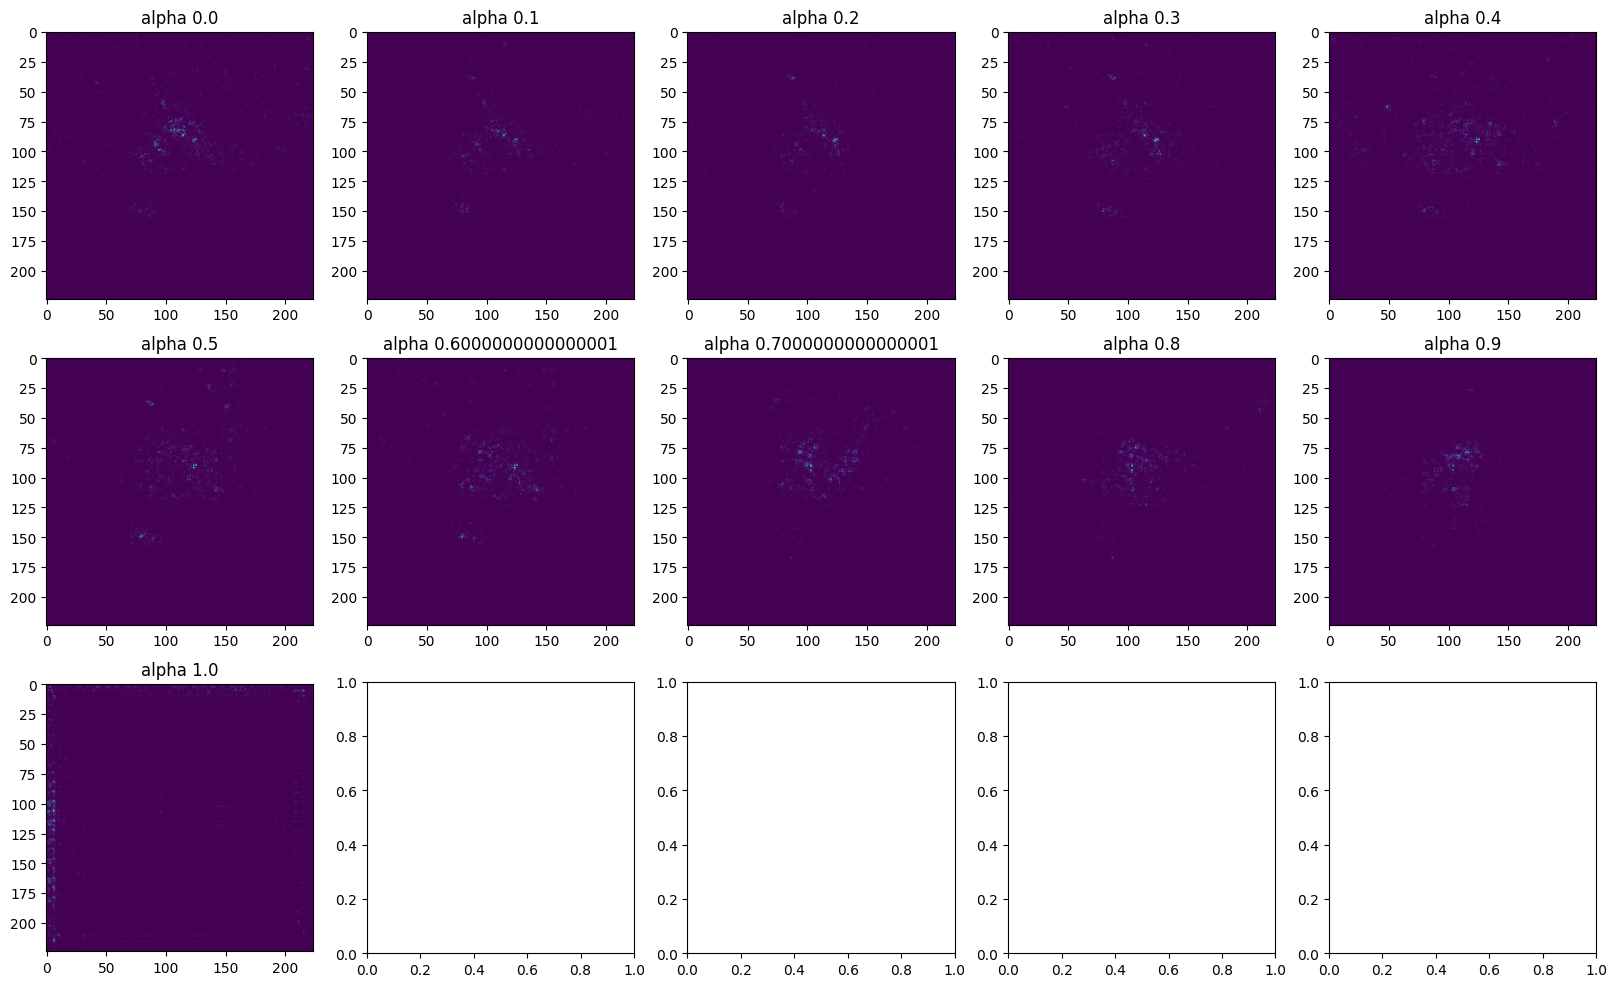

In [23]:
image_index = 9
temp_data = project_metadata.loc[
    (
        "vanilla_grad_mask",
        "meanx",
        image_index,
        "static"
    ),
    "data_path",
].apply(lambda x: np.load(x))
temp_data = preprocess_masks(temp_data, preprocesses=[sum_channels,symmetric_minmax_normalize,lambda x: x**2])
print(temp_data.index.names)
titles = temp_data.index.to_series().apply(lambda x: f"alpha {x}")
plot_masks(temp_data, titles=titles, imshow_args=imshow_args, ncols=5)

In [21]:
temp_metadata = project_metadata.loc[("log_probs", "meanx", slice(None), "static"), :]
meanx = temp_metadata.loc[:, "data_path"].apply(lambda path: np.load(path))

meanx.name = "values"
get_top_k = 1
pred_ids = meanx.apply(lambda x: np.argpartition(x, -get_top_k)[-get_top_k:])
pred_ids.name = "pred_ids"
pred_ids = pred_ids.to_frame()
alphas = pred_ids.index.get_level_values("alpha_mask_value")
pred_ids = pred_ids.explode("pred_ids")
pred_ids = pred_ids.groupby("image_index")["pred_ids"].unique().to_frame()
pred_ids = pred_ids.explode("pred_ids")
pred_ids = pd.concat(
    {alpha: pred_ids for alpha in alphas}, names=["alpha_mask_value"], axis=0
)

temp_df = pred_ids.apply(
    lambda x: meanx.loc[("log_probs", "meanx", x.name[1], "static", x.name[0]),][
        x["pred_ids"]
    ],
    axis=1,
)
temp_df.name = "meanx"
temp_df = np.exp(temp_df)
pred_ids["pred_ids"] = pred_ids["pred_ids"].apply(lambda x: IMAGENET_LABELS[x].split(",")[0])
pred_ids = pd.concat([pred_ids, temp_df], axis=1)

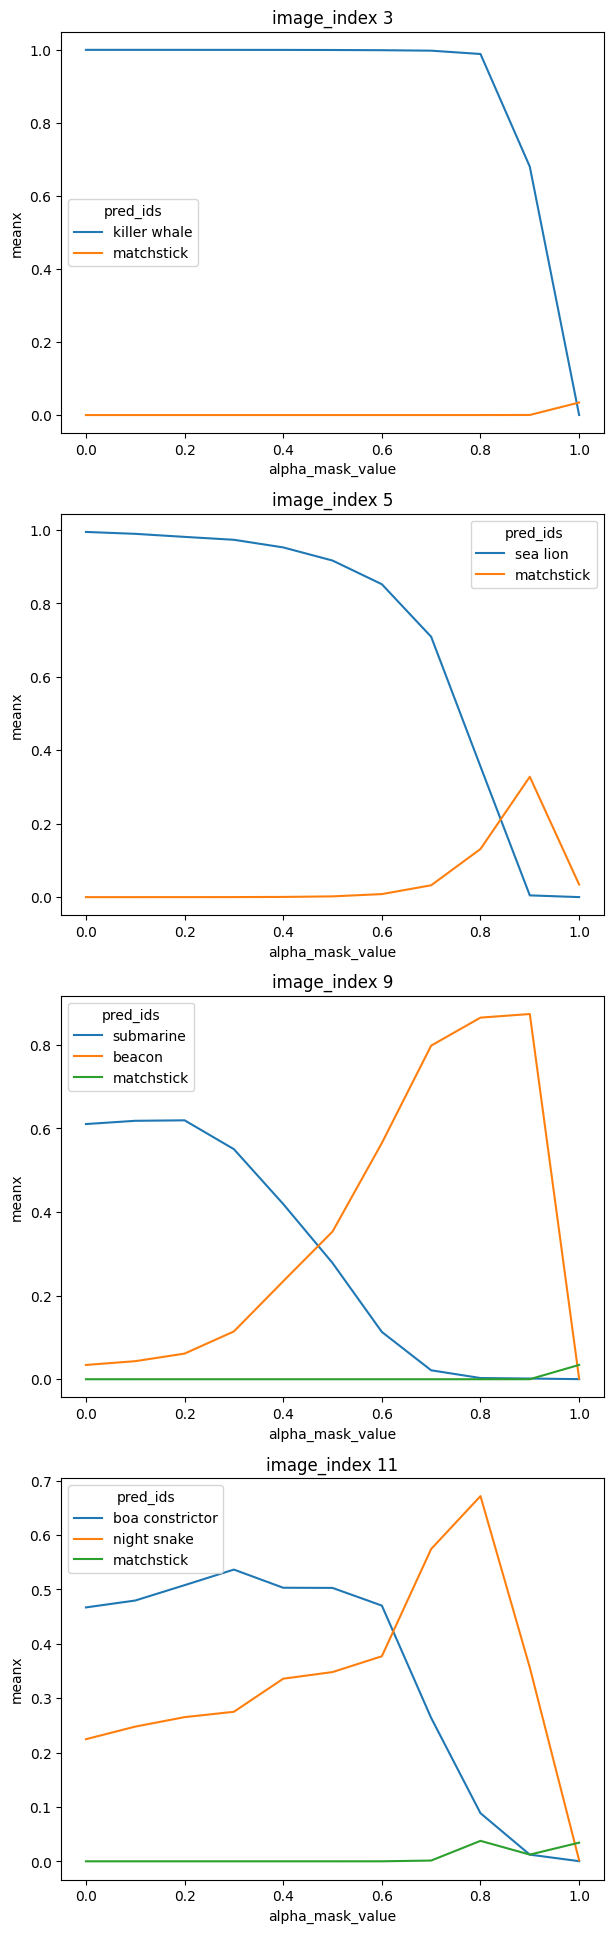

In [22]:
groups = pred_ids.reset_index().groupby("image_index")
nrows= len(image_indices)
fig,axes = plt.subplots(nrows,1,figsize=(7,6*nrows))
for i,(name, group) in enumerate(groups):
    sns.lineplot(
        ax = axes[i],
        x="alpha_mask_value",
        y="meanx",
        hue="pred_ids",
        data=group,
        palette="tab10",
    )
    axes[i].set_title(f"image_index {name}")